<a href="https://colab.research.google.com/github/amina01/Learning-Neural-Activations/blob/master/Copy_of_cifar10_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""

MobileNetv2 code taken from https://github.com/digantamisra98/Mish/blob/master/Notebooks/cifar-10-mobilenetv2-mish.ipynb

"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input"))

import time

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader



train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define training dataloader
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        train_transform: transfroms for train dataset
        path: path to cifar100 training python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: train_data_loader:torch dataloader object
    """

    transform_train = train_transform
    cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_training_loader

# define test dataloader
def get_testing_dataloader(test_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        test_transform: transforms for test dataset
        path: path to cifar100 test python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: cifar100_test_loader:torch dataloader object
    """

    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(
        cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader



# Define AFU
class AF(nn.Module):
    def __init__(self):
        super(AF, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        

        z = x.shape
        x = x.flatten().unsqueeze(1)
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        
        return x.view(z)



def f_mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))

# implement class wrapper for mish activation function
class mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_mish(input)
    
    
    
    
# implement swish activation function
def f_swish(input):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input)

# implement class wrapper for swish activation function
class swish(nn.Module):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = swish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_swish(input)
    
    
    
    
class DepthSeperabelConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, activation = 'relu', **kwargs):
        super().__init__()
        
        
        if (activation == 'relu'):
            f_activation =  nn.ReLU(inplace=True)
            
        if (activation == 'swish'):
            f_activation =  swish()
            
        if (activation == 'mish'):
            f_activation =  mish()
        if (activation == 'AF'):
            f_activation =  AF()
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                **kwargs),
            nn.BatchNorm2d(input_channels),
            f_activation
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            f_activation
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x
    
    
class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, activation = 'relu', **kwargs):

        super().__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        
        if (activation == 'relu'):
            self.activation =  nn.ReLU(inplace=True)
            
        if (activation == 'swish'):
            self.activation =  swish()
            
        if (activation == 'mish'):
            self.activation =  mish()
        if (activation == 'AF'):
            self.activation =  AF()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        return x
    
    
    


class MobileNet(nn.Module):

    """
    Args:
        width multipler: The role of the width multiplier α is to thin 
                         a network uniformly at each layer. For a given 
                         layer and width multiplier α, the number of 
                         input channels M becomes αM and the number of 
                         output channels N becomes αN.
    """

    def __init__(self, width_multiplier=1, class_num=100, activation = 'relu'):
        super().__init__()
        
        alpha = width_multiplier
        self.stem = nn.Sequential(
           BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False, activation = activation),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           )
       )
        self.conv1 = nn.Sequential(
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(128 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           )
       )
        self.conv2 = nn.Sequential(
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(256 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(256 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           )
       )
        self.conv3 = nn.Sequential(
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(512 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False,
               activation = activation
           ),

           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           )
       )
        self.conv4 = nn.Sequential(
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(1024 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False,
               activation = activation
           ),
           DepthSeperabelConv2d(
               int(1024 * alpha),
               int(1024 * alpha),
               3,
               padding=1,
               bias=False,
               activation = activation
           )
       )
        self.fc = nn.Linear(int(1024 * alpha), class_num)
        self.avg = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def mobilenet(alpha=1, class_num=10, activation = 'relu'):
    return MobileNet(alpha, class_num, activation)






trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)



epochs = 100
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")



model = mobilenet(activation = 'AF')


# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)



train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy'])


model.to(device)


steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    model.train()
    
train_stats.to_csv('train_log_MobileNet_Mish.csv')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100.. Time per epoch: 158.4601.. Average time per step: 0.4053.. Train loss: 1.7890.. Train accuracy: 0.3162.. Top-3 train accuracy: 0.6506.. Test loss: 1.6113.. Test accuracy: 0.4273.. Top-3 test accuracy: 0.7505
Epoch 2/100.. Time per epoch: 158.1166.. Average time per step: 0.4044.. Train loss: 1.3409.. Train accuracy: 0.5073.. Top-3 train accuracy: 0.8287.. Test loss: 1.2527.. Test accuracy: 0.5546.. Top-3 test accuracy: 0.8512
Epoch 3/100.. Time per epoch: 158.2539.. Average time per step: 0.4047.. Train loss: 1.1485.. Train accuracy: 0.5864.. Top-3 train accuracy: 0.8697.. Test loss: 1.0447.. Test accuracy: 0.6221.. Top-3 test accuracy: 0.8918
Epoch 4/100.. Time per epoch: 158.3521.. Average time per step: 0.4050.. Train loss: 1.0086.. Train accuracy: 0.6403.. Top-3 train accuracy: 0.8986.. Test loss: 0.9281.. Test accuracy: 0.6745.. Top-3 test accuracy: 0.9125
Epoch 5/100.. Time per epoch: 158.36

Text(0, 0.5, 'g(z)')

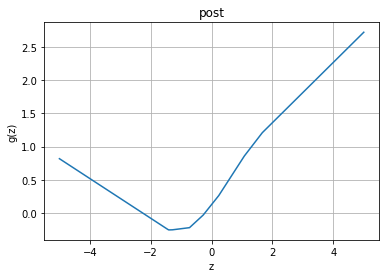

In [0]:
# Plotting the learnt AFU
import matplotlib.pyplot as plt
from torch.autograd import Variable
plt.figure();z = torch.linspace(-5,5,1000); 
z=Variable(z).type(torch.cuda.FloatTensor)
plt.plot(z.cpu().numpy(),model.stem[0].activation(z.unsqueeze(-1)).detach().cpu().numpy());
plt.grid(); plt.title("post"); plt.xlabel('z'); plt.ylabel('g(z)')  



In [0]:
print (model.stem[0].activation)

AF(
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
